In [1]:
import os

# set environment variables to limit cpu usage
# os.environ["OMP_NUM_THREADS"] = "4"  # export OMP_NUM_THREADS=4
# os.environ["OPENBLAS_NUM_THREADS"] = "4"  # export OPENBLAS_NUM_THREADS=4
# os.environ["MKL_NUM_THREADS"] = "4"  # export MKL_NUM_THREADS=6
# os.environ["VECLIB_MAXIMUM_THREADS"] = "4"  # export VECLIB_MAXIMUM_THREADS=4
# os.environ["NUMEXPR_NUM_THREADS"] = "4"  # export NUMEXPR_NUM_THREADS=6
os.environ["RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE"] = "1"

from pathlib import Path

import json

import ray
from ray import tune

import torch

from ptmz.loss_landscape.CKA_experiment import CKATrainable

import numpy as np

import pandas as pd

In [151]:
import json
import pandas as pd
from pathlib import Path

def read_json_line(file_path, line_number):
    """
    Read a specific line from a JSON file and return its content.

    Args:
        file_path (str): Path to the JSON file.
        line_number (int): The line number to read (0-based index).

    Returns:
        dict: The parsed JSON object from the specified line.
    """
    with open(file_path, 'r') as f:
        for current_line_number, line in enumerate(f):
            if current_line_number == line_number:
                return json.loads(line)
    raise IndexError(f"Line {line_number} not found in file {file_path}.")

def compile_configs(root_dir, line_number):
    """
    Compile configurations from specific lines of result.json files in the directory structure.

    Args:
        root_dir (str): The root directory containing the configuration directories.
        line_number (int): The line number to read from each result.json file.

    Returns:
        pd.DataFrame: DataFrame of configurations.
    """
    # Create a Path object for the root directory
    root_path = Path(root_dir)

    # List to hold all the configurations and their paths
    data = []

    # Walk through the directory structure
    path_list = [pdx for pdx in root_path.iterdir() if pdx.is_dir()]
    for pdx in path_list:
        json_file = pdx.joinpath('result.json')    
        # Load the specific line from the JSON file
        try:
            result = read_json_line(json_file, line_number)
        except FileNotFoundError:
            print(f"File not found: {json_file}")
            continue
        except IndexError as e:
            print(e)
            continue
        
        # Unroll the 'config' dictionary into the main dictionary
        config = result.pop('config', {})
        result.update(config)
        
        # Append the configuration and the path to the data list
        result["file_path"] = str(json_file).replace("result.json", "")
        data.append(result)

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(data)

    return df

def create_experiment_dataframe(
    model_dataframe,
    vary_keys=["seed"],
    match_keys=["training::batchsize", "model::width"],
):
    """
    Create a DataFrame of experiments to run.

    Args:
        model_dataframe (pd.DataFrame): DataFrame containing the model configurations
        vary_keys (list): list of keys to vary in the experiments
        match_keys (list): list of keys to match in the experiments

    Returns:
        pd.DataFrame: DataFrame of experiments to run with matched configurations and model paths
    """
    
    # Check if input is a DataFrame
    if not isinstance(model_dataframe, pd.DataFrame):
        raise ValueError("The model_dataframe should be a pandas DataFrame.")
    
    # Check if all vary_keys and match_keys are in the DataFrame columns
    for key in vary_keys + match_keys:
        if key not in model_dataframe.columns:
            raise ValueError(f"Key '{key}' not found in DataFrame columns.")
    
    # Group the dataframe by the match_keys
    grouped = model_dataframe.groupby(match_keys)
    
    experiment_list = []
    
    # Iterate over each group
    for match_values, group in grouped:
        # Get the matching part as a dictionary
        match_dict = dict(zip(match_keys, match_values))
        
        # Get the list of file paths for the current group
        model_paths = group['file_path'].tolist()
        
        # Average the numerical columns
        numerical_cols = group.select_dtypes(include='number').columns
        avg_values = group[numerical_cols].mean().to_dict()
        
        # Create a record with matching keys, averaged values, and model paths
        record = {**match_dict, **avg_values, 'model_paths': model_paths}
        
        experiment_list.append(record)
    
    # Convert the list of records to a DataFrame
    experiments_df = pd.DataFrame(experiment_list)
    
    return experiments_df

def mean_of_list(cell):
    """
    Calculate the mean of a list of values in a cell.

    Args:
        cell (list): A list of numerical values.

    Returns:
        float: The mean of the list or NaN if the cell is not a list.
    """
    if isinstance(cell, list):
        try:
            return np.mean(np.array(cell))
        except:
            return np.nan
    return np.nan

def aggregate_results_in_dfs(df,aggregate_keys):
    df_out = df.copy()
    df_out[aggregate_keys] = df[aggregate_keys].applymap(mean_of_list)
    return df_out


import pandas as pd

def merge_dataframes_on_key(dataframes, key):
    """
    Merge a list of DataFrames on a specified key.

    Args:
        dataframes (list): List of pandas DataFrames to merge.
        key (str): The key column to merge on. The column should contain lists.

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    def convert_to_frozenset(df, column_name):
        df[column_name] = df[column_name].apply(frozenset)
        return df

    # Ensure the key is present in all DataFrames
    for df in dataframes:
        if key not in df.columns:
            raise ValueError(f"Key '{key}' not found in DataFrame columns.")
    
    # Convert the key column to frozenset for merging
    dataframes = [convert_to_frozenset(df, key) for df in dataframes]

    # Merge all DataFrames on the specified key
    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on=key, how='inner')
    
    # Convert frozensets back to lists in the key column
    merged_df[key] = merged_df[key].apply(list)
    
    return merged_df


def read_model_data(
    root_models,
    root_cka,
    root_hessian,
    root_curve,
    root_wiseft,
    root_gitrebasin,
    epoch=100,
):
    dfs = []
    
    # read model data
    if root_models is not None:
        # read model data
        config_df = compile_configs(root_models,epoch)
        # clean exp config
        keys_to_retain_exp = ['train_loss', 'train_acc', 'test_loss', 'test_acc',
               'training_iteration', 'model::type','model::width',
               'seed',
               'training::batchsize', 'file_path']
        data_df = config_df[keys_to_retain_exp].copy()
        # compute exp config
        exp_df = create_experiment_dataframe(data_df)
        # append output
        print(f'found {len(exp_df)} experiment data')
        dfs.append(exp_df)
    
    # read cka data
    if root_cka is not None:
        # read raw data
        config_cka = compile_configs(root_cka,0)
        # drop unnecessary columns
        keys_to_retain_cka = ['representation_similarity',
               'representation_similarity_pairs', 'model_paths', 'epoch',
               'file_path']
        data_cka = config_cka[keys_to_retain_cka].copy()
        # aggregate repeated values
        cka_aggregate_keys = ["representation_similarity","representation_similarity_pairs"]
        df_cka_clean = aggregate_results_in_dfs(data_cka,cka_aggregate_keys)
        # append
        print(f'found {len(df_cka_clean)} cka data')
        dfs.append(df_cka_clean)
    
    # read hessian data
    if root_hessian is not None:
        config_hessian = compile_configs(root_hessian,0)
        # drop unnecessary columns
        keys_to_retain_hessian = ['hessian_top_eigenvalues_train_list', 'hessina_trace_train_list',
               'hessian_top_eigenvalues_train_mean', 'hessian_trace_train_mean', 'hessian_top_eigenvalues_val_list',
               'hessina_trace_val_list', 'hessian_top_eigenvalues_val_mean',
               'hessian_trace_val_mean', 'model_paths',
               'hessian_batch_size', 'hessian_number_batches',
               'file_path']
       
        data_hessian = config_hessian[keys_to_retain_hessian].copy()
        # compute log eigenvalues
        data_hessian['log_hessian_top_ev_train'] = np.log(data_hessian['hessian_top_eigenvalues_train_mean'])
        data_hessian['log_hessian_trace_train'] = np.log(data_hessian['hessian_trace_train_mean'])
        data_hessian['log_hessian_top_ev_val'] = np.log(data_hessian['hessian_top_eigenvalues_val_mean'])
        data_hessian['log_hessian_trace_val'] = np.log(data_hessian['hessian_trace_val_mean'])
        # append
        print(f'found {len(data_hessian)} hessian data')
        dfs.append(data_hessian)

    # read curve data
    if root_curve is not None:
        # read data
        config_curve = compile_configs(root_curve,0)
        # extract stats data
        df_curve = unroll_curve_dict(config_curve,"aggregated")
        # clean df
        keys_to_retain_curve = [
               'model_paths', 'epoch', 'file_path', 'mc_train_loss',
               'mc_test_loss', 'mc_train_error', 'mc_test_error']
        data_curve = df_curve[keys_to_retain_curve].copy()    
        # change keys
        new_names = {}
        for key in data_curve.keys():
            if key=='model_paths':
                continue
            new_names[key]=f'curve_{key}'
        data_curve.rename(columns=new_names,inplace=True)
        # append
        print(f'found {len(data_curve)} curve data')
        dfs.append(data_curve)
        
    # read MC data
    if root_wiseft is not None:
        # load raw data
        config_wiseft = compile_configs(root_wiseft,0)
        # get aggregated data
        df_wiseft = unroll_dict(config_wiseft,"aggregated")
        # clean df
        keys_to_retain_wiseft = ['model_paths', 'epoch_list_x',
               'align_models', 'file_path', 'epoch_list_y', 'loss_train', 'loss_test',
               'acc_train', 'acc_test']
        data_wiseft = df_wiseft[keys_to_retain_wiseft].copy()    
        new_names = {}
        for key in data_wiseft.keys():
            if key=='model_paths':
                continue
            new_names[key]=f'wiseft_{key}'
        data_wiseft.rename(columns=new_names,inplace=True)
        # append
        print(f'found {len(data_wiseft)} wiseft data')
        dfs.append(data_wiseft)

        # read MC data
    if root_gitrebasin is not None:
        # load raw data
        config_gitrebasin = compile_configs(root_gitrebasin,0)
        # clean df
        keys_to_retain_gitrebasin = ['model_paths', 'align_models', 'file_path', 'loss_train', 'loss_test', 'acc_train', 'acc_test']
        data_gitrebasin = config_gitrebasin[keys_to_retain_gitrebasin].copy()    
        # get values out of list
        for key in data_gitrebasin.keys():
            data_gitrebasin[key] = data_gitrebasin[key].apply(extract_single_value)
        # rename
        new_names = {}
        for key in data_gitrebasin.keys():
            if key=='model_paths':
                continue
            new_names[key]=f'gitrebasin_{key}'
        data_gitrebasin.rename(columns=new_names,inplace=True)
        
        # append
        print(f'found {len(data_gitrebasin)} gitrebasin data')
        dfs.append(data_gitrebasin)
    # clean MC data
    
    # merge
    df_merged = merge_dataframes_on_key(dfs, 'model_paths')

    # return
    return df_merged

# Function to unroll the dictionary with lists into separate columns
def unroll_dict(df, dict_column):
    # Create a DataFrame to store the unrolled columns

    dict_list = df[dict_column].to_list()

    aggregated_dict = {}
    for key in dict_list[0].keys():
        aggregated_dict[key] = []
    for ddx in dict_list:
        for key in aggregated_dict.keys():
            aggregated_dict[key].append(ddx[key][0])

    unrolled_df = pd.DataFrame(aggregated_dict)

    merged_df = pd.merge(df, unrolled_df, left_index=True, right_index=True)

    
    return merged_df

# Function to unroll the dictionary with lists into separate columns
def unroll_curve_dict(df, dict_column):
    # Create a DataFrame to store the unrolled columns

    dict_list = df[dict_column].to_list()

    aggregated_dict = {}
    for key in ['train_loss', 'test_loss', 'train_error', 'test_error']:
        new_key = f'mc_{key}'
        aggregated_dict[new_key] = []
    for ddx in dict_list:
        for key in ['train_loss', 'test_loss', 'train_error', 'test_error']:
            new_key = f'mc_{key}'
            aggregated_dict[new_key].append(ddx['mc'][key])
    
    unrolled_df = pd.DataFrame(aggregated_dict)

    merged_df = pd.merge(df, unrolled_df, left_index=True, right_index=True)

    
    return merged_df

def extract_single_value(cell):
    if isinstance(cell, list) and len(cell) == 1:
        return cell[0]
    return cell

In [152]:
epoch = 115
root = Path('/ds2/model_zoos/taxonomy/cifar_10/zoos/Cifar-10/Resnet18_width_v2')
root_zoo = root.joinpath(
        "tune_zoo_cifar-10_Resnet18_width_kaiming_uniform_150eps_width_2-256"
    )
root_cka = None
root_cka = root.joinpath(
        f"CKA_cifar-10_Resnet18_width_kaiming_uniform_{epoch}eps_width_2-256"
    )
root_hessian = None
root_hessian = root.joinpath(
        f"hessian_cifar-10_Resnet18_width_kaiming_uniform_{epoch}eps_width_2-256"
    )
root_curve = None
root_curve = root.joinpath(
        f"curve_cifar-10_Resnet18_width_kaiming_uniform_{epoch}eps_width_2-256_bs128"
    )
root_wiseft = None
root_wiseft = root.joinpath( 
        f"model_average_epochs_cifar-10_Resnet18_width_kaiming_uniform_{epoch}eps_width_2-256"
    )
root_gitrebasin = None
root_gitrebasin = root.joinpath( 
        f"model_average_seeds_cifar-10_Resnet18_width_kaiming_uniform_{epoch}eps_width_2-256"
    )


In [153]:
df_merged = read_model_data(
    root_models=root_zoo,
    root_cka=root_cka,
    root_hessian=root_hessian,
    root_curve=root_curve,
    root_wiseft = root_wiseft,
    root_gitrebasin = root_gitrebasin,
    epoch=epoch,
)

found 56 experiment data
found 56 cka data
found 56 hessian data
found 56 curve data
found 56 wiseft data
found 56 gitrebasin data


In [154]:
df_merged.keys()

Index(['training::batchsize', 'model::width', 'train_loss', 'train_acc',
       'test_loss', 'test_acc', 'training_iteration', 'seed', 'model_paths',
       'representation_similarity', 'representation_similarity_pairs', 'epoch',
       'file_path_x', 'hessian_top_eigenvalues_train_list',
       'hessina_trace_train_list', 'hessian_top_eigenvalues_train_mean',
       'hessian_trace_train_mean', 'hessian_top_eigenvalues_val_list',
       'hessina_trace_val_list', 'hessian_top_eigenvalues_val_mean',
       'hessian_trace_val_mean', 'hessian_batch_size',
       'hessian_number_batches', 'file_path_y', 'log_hessian_top_ev_train',
       'log_hessian_trace_train', 'log_hessian_top_ev_val',
       'log_hessian_trace_val', 'curve_epoch', 'curve_file_path',
       'curve_mc_train_loss', 'curve_mc_test_loss', 'curve_mc_train_error',
       'curve_mc_test_error', 'wiseft_epoch_list_x', 'wiseft_align_models',
       'wiseft_file_path', 'wiseft_epoch_list_y', 'wiseft_loss_train',
       'wiseft_lo

In [164]:
if root_wiseft is not None: 
    df_merged['wiseft_acc_train_delta'] = df_merged['wiseft_acc_train']-df_merged['train_acc']
    df_merged['wiseft_acc_test_delta'] = df_merged['wiseft_acc_test']-df_merged['test_acc']
    df_merged['wiseft_loss_train_delta'] = df_merged['wiseft_loss_train']-df_merged['train_loss']
    df_merged['wiseft_loss_test_delta'] = df_merged['wiseft_loss_test']-df_merged['test_loss']
if root_gitrebasin is not None: 
    df_merged['gitrebasin_acc_train_delta'] = df_merged['gitrebasin_acc_train']-df_merged['train_acc']
    df_merged['gitrebasin_acc_test_delta'] = df_merged['gitrebasin_acc_test']-df_merged['test_acc']
    df_merged['gitrebasin_loss_train_delta'] = df_merged['gitrebasin_loss_train']-df_merged['train_loss']
    df_merged['gitrebasin_loss_test_delta'] = df_merged['gitrebasin_loss_test']-df_merged['test_loss']
df_merged['ggap'] = df_merged['train_acc']-df_merged['test_acc']
df_merged['training::batchsize'] = df_merged['training::batchsize'].astype('int')
df_merged['model::width'] = df_merged['model::width'].astype('int')

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# fig_list = ["test_acc","train_loss",'ggap',"representation_similarity", "log_hessian_top_ev","log_hessian_trace",'curve_mc_train_loss', 'curve_mc_test_loss','curve_mc_train_error', 'curve_mc_test_error','wiseft_acc_train_delta','wiseft_acc_test_delta','wiseft_loss_train_delta','wiseft_loss_test_delta']
fig_list = ["test_acc","train_loss",'ggap']#,"representation_similarity", "log_hessian_top_ev","log_hessian_trace",'curve_mc_train_loss', 'curve_mc_test_loss','curve_mc_train_error', 'curve_mc_test_error','wiseft_acc_train_delta','wiseft_acc_test_delta','wiseft_loss_train_delta','wiseft_loss_test_delta']

num_cols = 4
num_plots = len(fig_list)
num_rows = int(np.ceil(num_plots / num_cols))


fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows,figsize=(5*num_cols,5*num_rows),dpi=300)

axes = ax.flatten()

for idx,fig_key in enumerate(fig_list):
    
    df_fig = df_merged.pivot_table(index='training::batchsize', columns='model::width', values=fig_key)

    # Create the heatmap
    adx = axes[idx]
    sns.heatmap(df_fig, annot=True, cmap='viridis', cbar=True,ax=adx)
    adx.set_title(f'{fig_key}')
    adx.set_xlabel('Model Width')
    adx.set_ylabel('Training Batch Size')

fig.tight_layout()
plt.show()


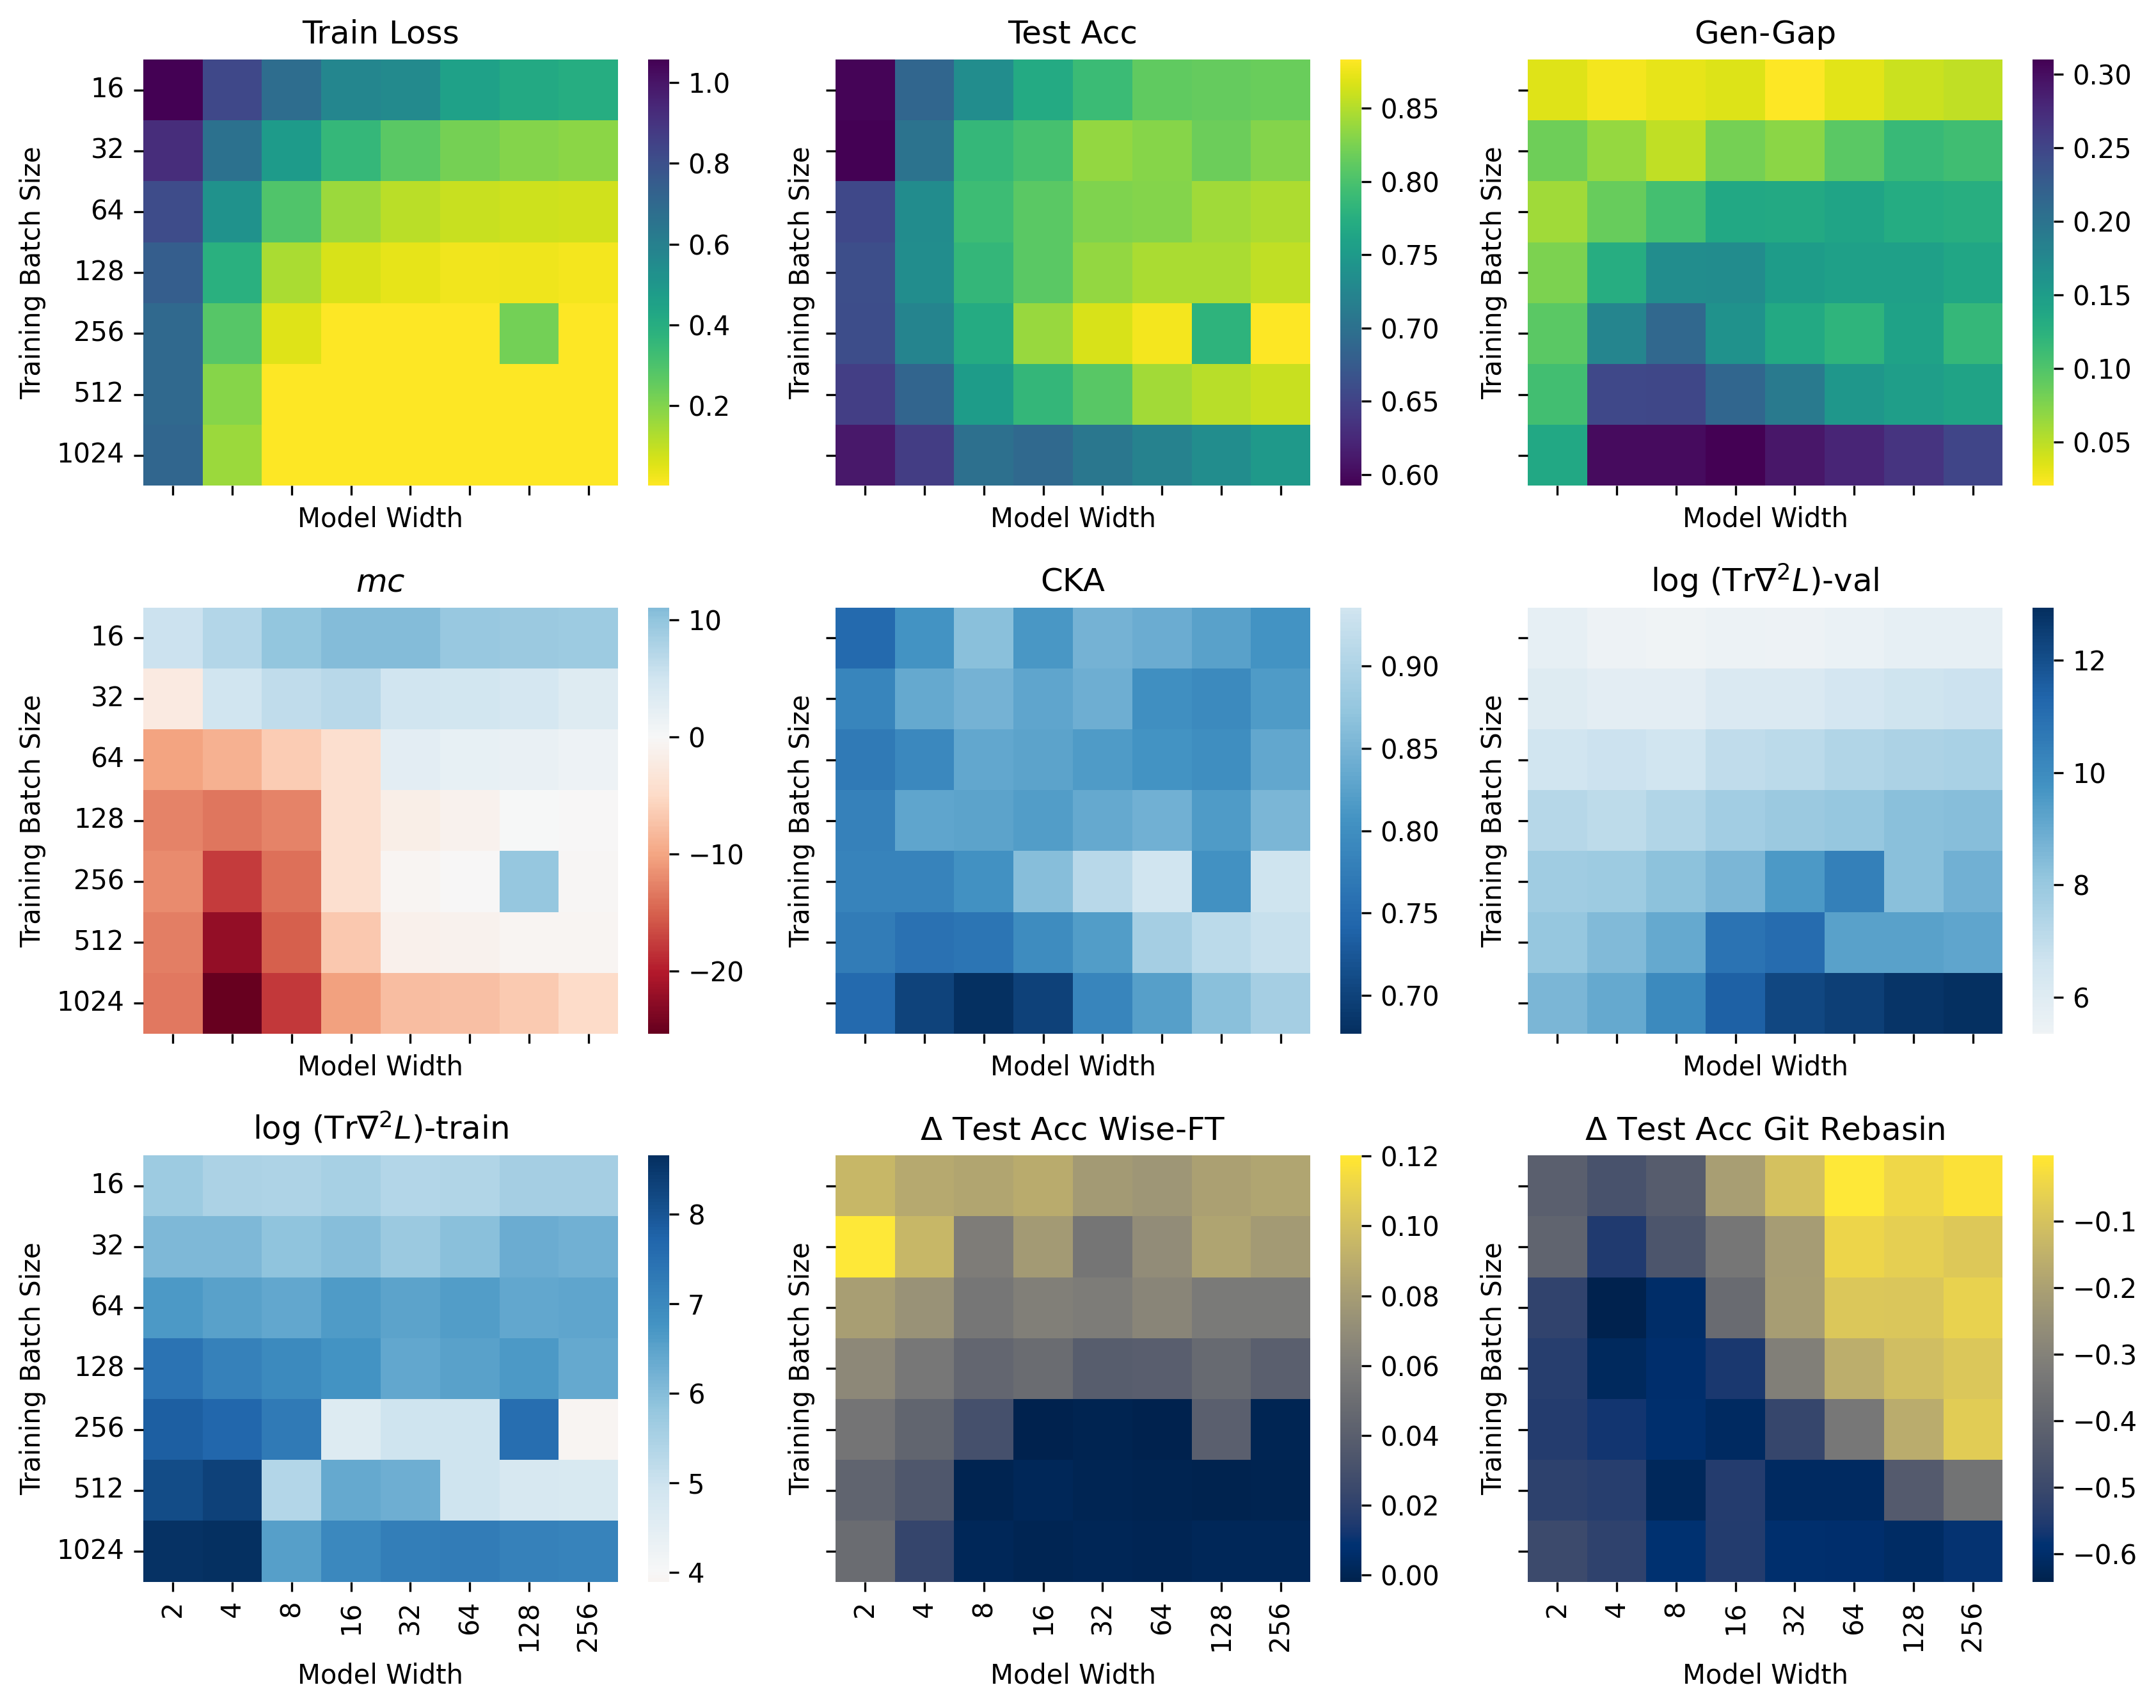

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# fig_list = ["test_acc","train_loss","ggap","representation_similarity", "log_hessian_top_ev","log_hessian_trace",'curve_mc_train_error', 'curve_mc_test_error','wiseft_acc_train_delta','wiseft_acc_test_delta']
# fig_list = ["test_acc","train_loss","ggap","representation_similarity", "log_hessian_top_ev","log_hessian_trace",'curve_mc_train_error','wiseft_acc_test_delta']
# fig_list = [["test_acc","ggap"],["train_loss",'curve_mc_train_error'],["log_hessian_top_ev","representation_similarity"],[ "log_hessian_trace",'wiseft_acc_test_delta']]
# fig_list = [["train_loss","test_acc","ggap"],['curve_mc_train_error',"representation_similarity","log_hessian_top_ev_train"],[ "log_hessian_trace_train",'wiseft_acc_test_delta','gitrebasin_acc_test_delta']]
fig_list = [["train_loss","test_acc","ggap"],['curve_mc_train_error',"representation_similarity","log_hessian_trace_val"],[ "log_hessian_trace_train",'wiseft_acc_test_delta','gitrebasin_acc_test_delta']]

# centered = ['curve_mc_train_error', 'curve_mc_test_error']
centered = {
    'curve_mc_train_error':[0, False], 
    'curve_mc_test_error':[0, False],
    'representation_similarity':[1.0,True],
    'log_hessian_trace_train':[4, False],
    'log_hessian_trace_val':[5, False],
    'log_hessian_top_ev_train':[4, False],
    'log_hessian_top_ev_val':[5, False],
   }
perf_metrics = {
    'test_acc':False, 
    'ggap':True, 
    'train_loss':True, 
}
averaging_metrics = {
    'wiseft_acc_test_delta':False, 
    'gitrebasin_acc_test_delta':False, 
}
num_cols = 3
num_plots = len(fig_list)
num_rows = len(fig_list[0])

title_dict = {
    "train_loss": "Train Loss",
    "test_acc": "Test Acc",
    "ggap": "Gen-Gap",
    "curve_mc_train_error": r"$mc$",
    "log_hessian_top_ev": r"log$(\lambda_{max})$",
    "log_hessian_trace": r"log $($Tr$\nabla^2 L)$",
    "log_hessian_top_ev_train": r"log$(\lambda_{max})$-train",
    "log_hessian_trace_train": r"log $($Tr$\nabla^2 L)$-train",
    "log_hessian_top_ev_val": r"log$(\lambda_{max})$-val",
    "log_hessian_trace_val": r"log $($Tr$\nabla^2 L)$-val",
    "representation_similarity": r"CKA",
    "wiseft_acc_test_delta": r"$\Delta$ Test Acc Wise-FT",
    "gitrebasin_acc_test_delta": r"$\Delta$ Test Acc Git Rebasin",
}

fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows,figsize=(3.8*num_cols,3*num_rows),dpi=300,sharex=True,sharey=True)


for idx,fig_keys in enumerate(fig_list):
    for jdx,fig_key in enumerate(fig_keys):
        df_fig = df_merged.pivot_table(index='training::batchsize', columns='model::width', values=fig_key)
    
        # Create the heatmap
        adx = ax[idx,jdx]
    
        if fig_key in centered:
            center, inverted = centered[fig_key]
            # cmap = plt.cm.get_cmap('RdBu')
            cmap = plt.colormaps.get_cmap('RdBu')
            if inverted:
                # Invert the colormap
                cmap = cmap.reversed()
            sns.heatmap(df_fig, annot=False, cmap=cmap, center=center, cbar=True,ax=adx)
        elif fig_key in perf_metrics:
            inverted = perf_metrics[fig_key]
            cmap = plt.colormaps.get_cmap('viridis')
            if inverted:
                # Invert the colormap
                cmap = cmap.reversed()
            sns.heatmap(df_fig, annot=False, cmap=cmap, cbar=True,ax=adx)
        elif fig_key in averaging_metrics:
            inverted = averaging_metrics[fig_key]
            # cmap = sns.light_palette(color='green')
            # cmap = plt.colormaps.get_cmap('magma')
            cmap = plt.colormaps.get_cmap('cividis')
            if inverted:
                # Invert the colormap
                cmap = cmap.reversed()
            sns.heatmap(df_fig, annot=False, cmap=cmap, cbar=True,ax=adx)
        else:
            cmap = plt.colormaps.get_cmap('viridis')
            sns.heatmap(df_fig, annot=False, cmap=cmap, cbar=True,ax=adx)
        adx.set_title(f'{title_dict[fig_key]}')
        adx.set_xlabel('Model Width')
        adx.set_ylabel('Training Batch Size')

fig.tight_layout()
plt.show()


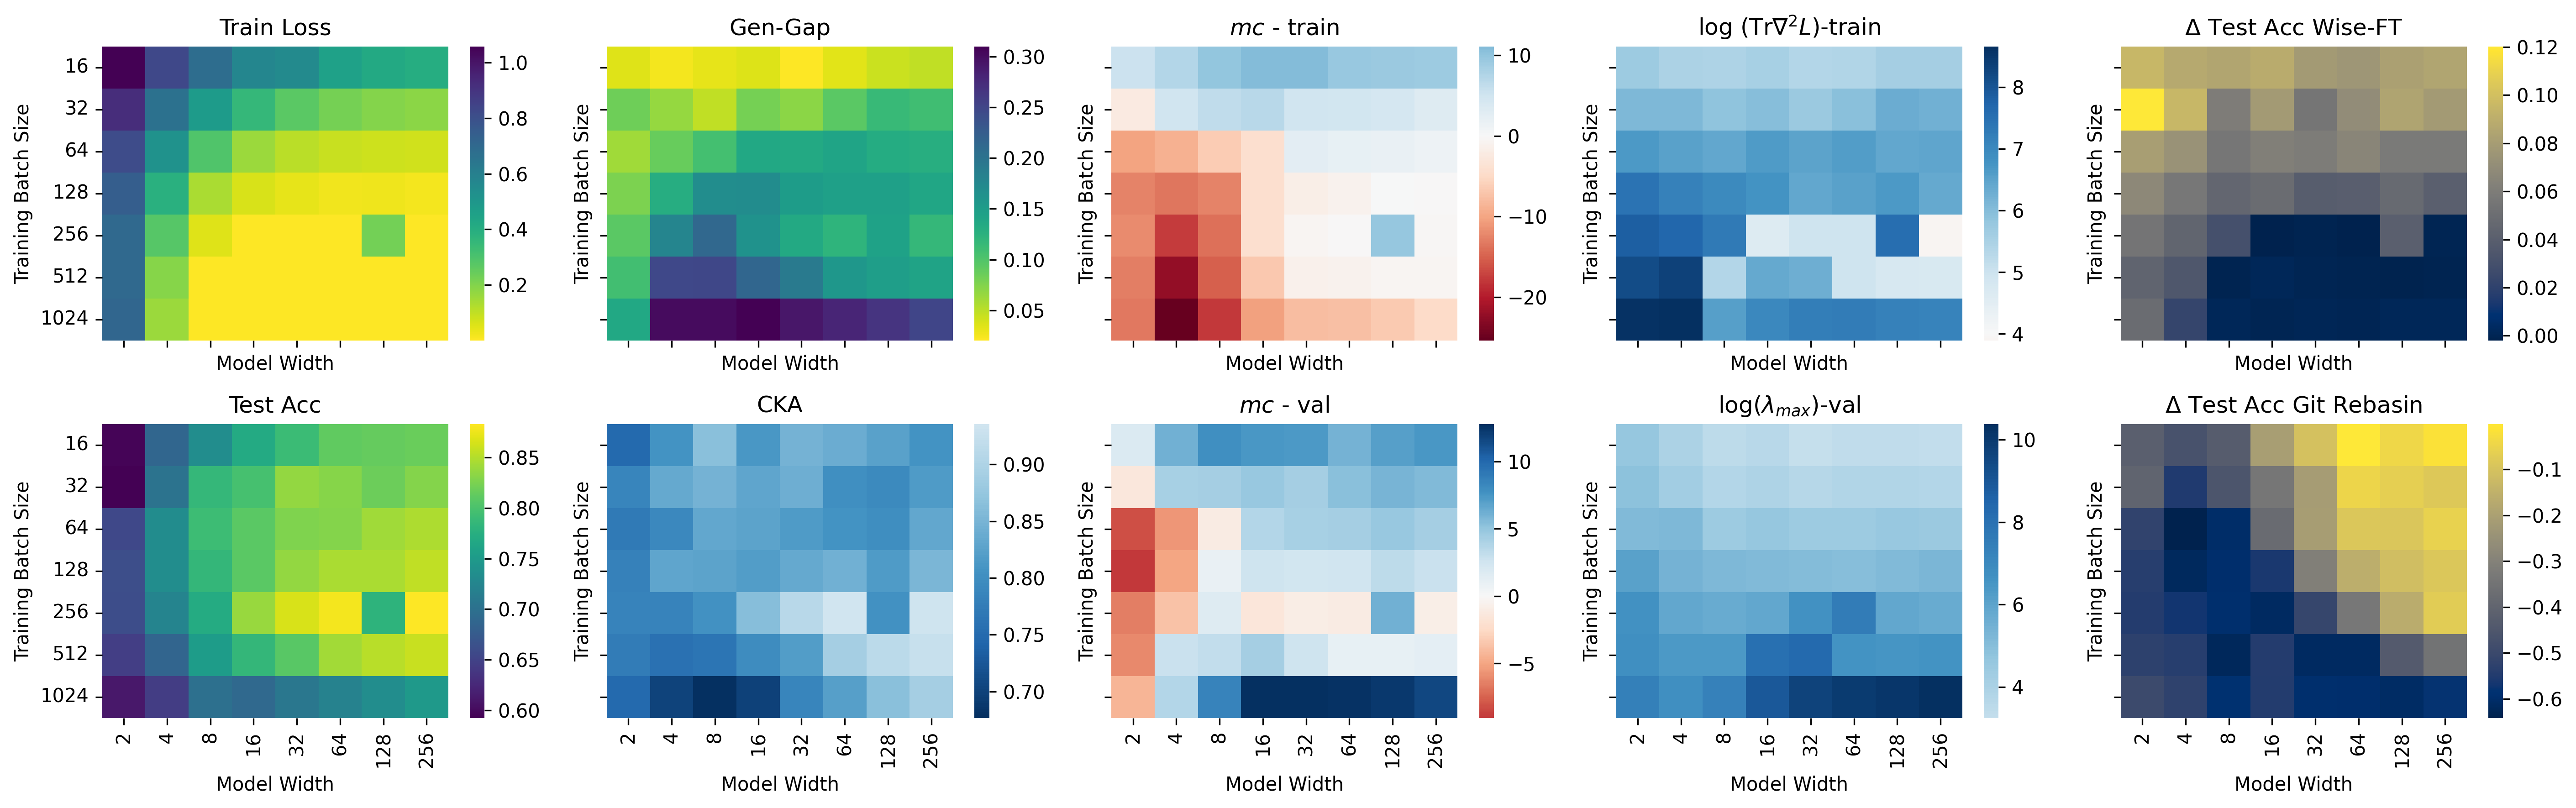

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


fig_list = [["train_loss","test_acc"],["ggap","representation_similarity"],['curve_mc_train_error','curve_mc_test_error'],
            # ["log_hessian_trace_train","log_hessian_trace_val"],['wiseft_acc_test_delta','gitrebasin_acc_test_delta']]
            ["log_hessian_trace_train","log_hessian_top_ev_val"],['wiseft_acc_test_delta','gitrebasin_acc_test_delta']]

# centered = ['curve_mc_train_error', 'curve_mc_test_error']
centered = {
    'curve_mc_train_error':[0, False], 
    'curve_mc_test_error':[0, False],
    'representation_similarity':[1.0,True],
    'log_hessian_trace_train':[4, False],
    'log_hessian_trace_val':[5, False],
    'log_hessian_top_ev_train':[1, False],
    'log_hessian_top_ev_val':[1, False],
   }
perf_metrics = {
    'test_acc':False, 
    'ggap':True, 
    'train_loss':True, 
}
averaging_metrics = {
    'wiseft_acc_test_delta':False, 
    'gitrebasin_acc_test_delta':False, 
}
num_cols = len(fig_list)
num_rows = len(fig_list[0])

title_dict = {
    "train_loss": "Train Loss",
    "test_acc": "Test Acc",
    "ggap": "Gen-Gap",
    "curve_mc_train_error": r"$mc$ - train",
    "curve_mc_test_error": r"$mc$ - val",
    "log_hessian_top_ev": r"log$(\lambda_{max})$",
    "log_hessian_trace": r"log $($Tr$\nabla^2 L)$",
    "log_hessian_top_ev_train": r"log$(\lambda_{max})$-train",
    "log_hessian_trace_train": r"log $($Tr$\nabla^2 L)$-train",
    "log_hessian_top_ev_val": r"log$(\lambda_{max})$-val",
    "log_hessian_trace_val": r"log $($Tr$\nabla^2 L)$-val",
    "representation_similarity": r"CKA",
    "wiseft_acc_test_delta": r"$\Delta$ Test Acc Wise-FT",
    "gitrebasin_acc_test_delta": r"$\Delta$ Test Acc Git Rebasin",
}

fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows,figsize=(3.8*num_cols,3*num_rows),dpi=300,sharex=True,sharey=True)


for idx,fig_keys in enumerate(fig_list):
    for jdx,fig_key in enumerate(fig_keys):
        df_fig = df_merged.pivot_table(index='training::batchsize', columns='model::width', values=fig_key)
    
        # Create the heatmap
        adx = ax[jdx,idx]
    
        if fig_key in centered:
            center, inverted = centered[fig_key]
            # cmap = plt.cm.get_cmap('RdBu')
            cmap = plt.colormaps.get_cmap('RdBu')
            if inverted:
                # Invert the colormap
                cmap = cmap.reversed()
            sns.heatmap(df_fig, annot=False, cmap=cmap, center=center, cbar=True,ax=adx)
        elif fig_key in perf_metrics:
            inverted = perf_metrics[fig_key]
            cmap = plt.colormaps.get_cmap('viridis')
            if inverted:
                # Invert the colormap
                cmap = cmap.reversed()
            sns.heatmap(df_fig, annot=False, cmap=cmap, cbar=True,ax=adx)
        elif fig_key in averaging_metrics:
            inverted = averaging_metrics[fig_key]
            # cmap = sns.light_palette(color='green')
            # cmap = plt.colormaps.get_cmap('magma')
            cmap = plt.colormaps.get_cmap('cividis')
            if inverted:
                # Invert the colormap
                cmap = cmap.reversed()
            sns.heatmap(df_fig, annot=False, cmap=cmap, cbar=True,ax=adx)
        else:
            cmap = plt.colormaps.get_cmap('viridis')
            sns.heatmap(df_fig, annot=False, cmap=cmap, cbar=True,ax=adx)
        adx.set_title(f'{title_dict[fig_key]}')
        adx.set_xlabel('Model Width')
        adx.set_ylabel('Training Batch Size')

fig.tight_layout()
plt.show()


# save data to results.json

In [109]:
import json
import shutil
from pathlib import Path

def modify_json_file(file_path, line_number, new_entry):
    """
    Modifies a specific line in a JSON file containing lines of dictionaries by adding a new entry.
    Creates a backup of the original file with a .bak extension.
    
    Args:
        file_path (Path): Path to the JSON file.
        line_number (int): The line number of the dictionary to be modified (0-based index).
        new_entry (dict): A dictionary containing the new entry to be added.
    """
    # Create a backup of the original file
    backup_path = file_path.with_suffix(file_path.suffix + '.bak')
    shutil.copyfile(file_path, backup_path)
    
    # Read the file and load each line as a dictionary
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Ensure the line number is within the valid range
    if line_number < 0 or line_number >= len(lines):
        raise ValueError("Invalid line number")
    
    # Load the specific line as a dictionary
    dict_line = json.loads(lines[line_number])
    
    # Add the new entry to the dictionary
    dict_line.update(new_entry)
    
    # Convert the dictionary back to a JSON string
    lines[line_number] = json.dumps(dict_line) + '\n'
    
    # Write the modified lines back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

In [110]:
epoch

115

In [112]:
from tqdm import tqdm
df_dict = {}
model_paths = df_merged.model_paths.to_list()
transfer_keys = ['representation_similarity', 'representation_similarity_pairs','log_hessian_top_ev', 'log_hessian_trace', 'curve_mc_train_error', 'wiseft_acc_test', 'wiseft_acc_test_delta']
for key in transfer_keys:
    df_dict[key] = df_merged[key].to_list()
# 'curve_mc_train_error'
for idx, path_list in tqdm(enumerate(model_paths)):
    for pdx in path_list:
        fname = Path(pdx).joinpath('result.json')
        new_dict = {}
        for key in transfer_keys:
            new_dict[key] = df_dict[key][idx]
        modify_json_file(file_path=fname, line_number=epoch, new_entry=new_dict)    

56it [00:34,  1.64it/s]


# compute Downstream tasks

In [113]:
## load checkpoint datasets
from ptmz.datasets.dataset_epochs import ModelDatasetBaseEpochs
import torch.nn as nn
import logging
from tqdm import tqdm

class StatsDataset(ModelDatasetBaseEpochs):
    def __init__(self,        
        root,
        epoch_lst=10,
        mode="checkpoint",
        train_val_test="train",  # determines whcih dataset split to use
        ds_split=[0.7, 0.3],  #
        max_samples=None,
        weight_threshold=float("inf"),
        filter_function=None,  # gets sample path as argument and returns True if model needs to be filtered out
        property_keys=None,
        num_threads=4,
        shuffle_path=True,
    ):
        # load general dataset
        super().__init__(root,epoch_lst,mode,train_val_test,ds_split,max_samples,weight_threshold,filter_function,property_keys,num_threads,shuffle_path)
        #

    def get_stats(self):
        lq = LayerQuintilesFromCheckpoint()
        # iterate over models
        stats = []
        for idx in tqdm(range(len(self.data))):
            stats.append([])
            for jdx in range(len(self.data[idx])):
                #
                stat_features = lq.compute_layer_quintiles(self.data[idx][jdx])
                stats[idx].append(stat_features)
        #
        self.stats = stats

    ## get_weights ####################################################################################################################################################################
    def __get_weights__(
        self,
    ):
        """
        Returns:
            torch.Tensor with full dataset as sequence of components [n_samples,n_tokens_per_sample,token_dim]
        """
        data_out = [self.stats[idx][jdx] for idx in range(len(self.stats)) for jdx in range(len(self.stats[idx]))]

        data_out = torch.stack(data_out)
        # flatten unterthiner featurs
        data_out = data_out.flatten(start_dim=1)
        mask_out = []
        logging.debug(f"shape of weight tensor: {data_out.shape}")
        self.pos = [torch.zeros(data_out.shape[1]) for _ in range(data_out.shape[0])]
        return data_out, mask_out
                                  


class LayerQuintilesFromCheckpoint(nn.Module):
    def __init__(
        self,
    ):
        super(LayerQuintilesFromCheckpoint, self).__init__()

    def compute_layer_quintiles(self, check):
        # weights need to be on the cpu for numpy
        quantiles = [1, 25, 50, 75, 99]
        features = []
        # iterate over layers
        for idx, key in enumerate(check.keys()):
            if not "weight" in key:
                continue
            if "bn" in key or "downsample.1" in key:
                continue
            weights = check[key]
            # print(f'{key}: {weights.shape}')
            wtmp = weights.detach().flatten(start_dim=0).numpy()
            # # compute kernel stat values
            features_ldx_weights = np.percentile(
                a=wtmp,
                q=quantiles,
                axis=0,
                )
            features_ldx_weights = torch.tensor(features_ldx_weights).unsqueeze(dim=0)
            mean_ldx_weights = torch.tensor(np.mean(a=wtmp, axis=0)).unsqueeze(dim=0).unsqueeze(dim=0)
            var_ldx_weights = torch.tensor(np.var(a=wtmp, axis=0)).unsqueeze(dim=0).unsqueeze(dim=0)
            # print(f'f: {features_ldx_weights.shape} - m: {mean_ldx_weights.shape} - v: {var_ldx_weights.shape}')
            fdx = torch.cat([mean_ldx_weights, var_ldx_weights, features_ldx_weights],dim=1)
            # print(fdx.shape)
            features.append(fdx)
            
            
        # put together
        z = torch.stack(features, dim=0)
        return z.squeeze()


In [114]:
result_key_list = ["test_acc", "training_iteration", "ggap", 'representation_similarity', 'representation_similarity_pairs','log_hessian_top_ev', 'log_hessian_trace', 'curve_mc_train_error', 'wiseft_acc_test', 'wiseft_acc_test_delta']
config_key_list = ["seed", "training::batchsize"]
property_keys = {
    "result_keys": result_key_list,
    "config_keys": config_key_list,
}

ds_train = StatsDataset(
    root=root_zoo,
    epoch_lst=[epoch],
    mode="checkpoint",
    train_val_test="train",  # determines whcih dataset split to use
    ds_split=[0.7, 0.15,0.15],
    property_keys=property_keys,
)
ds_val = StatsDataset(
    root=root_zoo,
    epoch_lst=[epoch],
    mode="checkpoint",
    train_val_test="val",  # determines whcih dataset split to use
    ds_split=[0.7, 0.15,0.15],
    property_keys=property_keys,
)
ds_test = StatsDataset(
    root=root_zoo,
    epoch_lst=[epoch],
    mode="checkpoint",
    train_val_test="test",  # determines whcih dataset split to use
    ds_split=[0.7, 0.15,0.15],
    property_keys=property_keys,
)
ds_train.get_stats()
ds_val.get_stats()
ds_test.get_stats()

2024-05-31 09:44:04,876	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [01:23<00:00,  1.40it/s]
load properties: 117it [00:08, 14.42it/s]
2024-05-31 09:47:01,641	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.33s/it]
load properties: 25it [00:03,  6.89it/s]
2024-05-31 09:48:11,539	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
100%|

In [115]:
from ptmz.models.def_downstream_module import (
    DownstreamTaskLearner as DownstreamTaskLearner,
)

from ptmz.models.downstream_baselines import IdentityModel, LayerQuintiles
from ptmz.datasets.dataset_tokens import DatasetTokens


In [116]:
dstk = DownstreamTaskLearner()
im = IdentityModel()

# compute dst perf
performance_im = dstk.eval_dstasks(
    model=im,
    trainset=ds_train,
    testset=ds_test,
    valset=ds_val,
    batch_size=128,
    task_keys = ["test_acc", "ggap", 'representation_similarity', 'representation_similarity_pairs','log_hessian_top_ev', 'log_hessian_trace', 'curve_mc_train_error', 'wiseft_acc_test', 'wiseft_acc_test_delta'],
)


Prepare embeddings


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:22<00:00,  2.47s/it]


In [117]:
performance_im

{'test_acc_train': 0.7064877666951328,
 'test_acc_test': 0.543168151359045,
 'test_acc_val': 0.8061722596700106,
 'ggap_train': 0.522006536743969,
 'ggap_test': 0.5391979625129493,
 'ggap_val': 0.40542763255998693,
 'representation_similarity_train': 0.4734232614755912,
 'representation_similarity_test': 0.46414813630908236,
 'representation_similarity_val': 0.40640111375094545,
 'representation_similarity_pairs_train': 0.4734232614755912,
 'representation_similarity_pairs_test': 0.46414813630908236,
 'representation_similarity_pairs_val': 0.40640111375094545,
 'log_hessian_top_ev_train': 0.40994590218867777,
 'log_hessian_top_ev_test': 0.5687287667634999,
 'log_hessian_top_ev_val': 0.3680235035334485,
 'log_hessian_trace_train': 0.5034635575277497,
 'log_hessian_trace_test': 0.6153112402917992,
 'log_hessian_trace_val': 0.4286414171514793,
 'curve_mc_train_error_train': 0.8212547202628544,
 'curve_mc_train_error_test': 0.8182508854666675,
 'curve_mc_train_error_val': 0.405794541713488

## transfer to cifar100 

In [118]:
result_key_list = ["test_acc", "training_iteration", "ggap", 'representation_similarity', 'representation_similarity_pairs','log_hessian_top_ev', 'log_hessian_trace', 'curve_mc_train_error', 'wiseft_acc_test', 'wiseft_acc_test_delta']
config_key_list = ["seed", "training::batchsize"]
property_keys = {
    "result_keys": result_key_list,
    "config_keys": config_key_list,
}
root_zoo_ood = Path("/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-100/Resnet18_width_v2/tune_zoo_cifar-100_Resnet18_width_kaiming_uniform_150eps_width_2-256")
epoch_ood = 115
ds_test_ood = StatsDataset(
    root=root_zoo_ood,
    epoch_lst=[epoch_ood],
    mode="checkpoint",
    train_val_test="train",  # determines whcih dataset split to use
    ds_split=[1.0, 0.0,0.0],
    property_keys=property_keys,
)
ds_test_ood.get_stats()

2024-05-31 10:14:18,622	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [01:55<00:00,  1.45it/s]
load properties: 168it [00:01, 99.96it/s] 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [03:14<00:00,  1.16s/it]


In [119]:
dstk = DownstreamTaskLearner()
im = IdentityModel()

# compute dst perf
performance_im = dstk.eval_dstasks(
    model=im,
    trainset=ds_train,
    testset=ds_test_ood,
    valset=ds_val,
    batch_size=128,
    task_keys = ["test_acc", "ggap", 'representation_similarity', 'representation_similarity_pairs','log_hessian_top_ev', 'log_hessian_trace', 'curve_mc_train_error', 'wiseft_acc_test', 'wiseft_acc_test_delta'],
)


Prepare embeddings


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.08s/it]


In [120]:
performance_im

{'test_acc_train': 0.7064877666951328,
 'test_acc_test': -6.2405968381810135,
 'test_acc_val': 0.8061722596700106,
 'ggap_train': 0.522006536743969,
 'ggap_test': -0.47630753535855663,
 'ggap_val': 0.40542763255998693,
 'representation_similarity_train': 0.4734232614755912,
 'representation_similarity_test': -1.7654394949588492,
 'representation_similarity_val': 0.40640111375094545,
 'representation_similarity_pairs_train': 0.4734232614755912,
 'representation_similarity_pairs_test': -1.7654394949588492,
 'representation_similarity_pairs_val': 0.40640111375094545,
 'log_hessian_top_ev_train': 0.40994590218867777,
 'log_hessian_top_ev_test': 0.10278223350793059,
 'log_hessian_top_ev_val': 0.3680235035334485,
 'log_hessian_trace_train': 0.5034635575277497,
 'log_hessian_trace_test': -0.07206785730447152,
 'log_hessian_trace_val': 0.4286414171514793,
 'curve_mc_train_error_train': 0.8212547202628544,
 'curve_mc_train_error_test': 0.19775631000640514,
 'curve_mc_train_error_val': 0.4057945

# get aggregated data

In [17]:


# clean df
keys_to_retain_curve = [
       'model_paths', 'epoch', 'file_path', 'mc_train_loss',
       'mc_test_loss', 'mc_train_error', 'mc_test_error']
data_curve = df_curve[keys_to_retain_curve].copy()    
new_names = {}
for key in data_curve.keys():
    if key=='model_paths':
        continue
    new_names[key]=f'curve_{key}'
data_curve.rename(columns=new_names,inplace=True)
data_curve

,model_paths,curve_epoch,curve_file_path,curve_mc_train_loss,curve_mc_test_loss,curve_mc_train_error,curve_mc_test_error
0,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-1.615162,1.312973,-48.225333,5.653333
1,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.331795,0.171138,-10.712000,-4.608333
2,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.959157,0.301628,-24.705333,4.528333
3,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.451449,-0.177726,-3.538667,0.661667
4,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-1.029729,0.160064,-30.912333,-9.480000
5,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-1.163683,0.640620,-33.153000,2.033333
6,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.584269,-0.446935,-0.251333,-2.438333
7,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.245892,0.380048,-1.610667,7.946667
8,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.442764,-0.365104,-1.703333,-3.150000
9,[/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar...,150,/ds2/model_zoos/taxonomy/cifar_100/zoos/Cifar-...,-0.667373,-0.478878,-0.162667,-2.223333


In [103]:
config_df = compile_configs(root_zoo,150)
# clean exp config
keys_to_retain_exp = ['train_loss', 'train_acc', 'test_loss', 'test_acc',
       'training_iteration', 'model::type','model::width',
       'seed',
       'training::batchsize', 'file_path']
data_df = config_df[keys_to_retain_exp].copy()

data_df["ggap"] = data_df["test_acc"] - data_df["train_acc"]

for key in ["train_loss","test_loss","train_acc","test_acc","ggap"]:
    ddx = data_df[key].to_numpy()
    print(f'{key} - {ddx.mean():2.2f}+-{ddx.std():2.2f} [{ddx.min():2.2f},{ddx.max():2.2f}]')

train_loss - 0.08+-0.19 [0.00,0.66]
test_loss - 0.67+-0.34 [0.32,1.98]
train_acc - 0.97+-0.06 [0.77,1.00]
test_acc - 0.82+-0.08 [0.65,0.91]
ggap - -0.16+-0.07 [-0.35,-0.04]
